# espagne.csv

# Data parsing

In [1]:
using PyPlot: pygui
pygui(true)
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
include("import_all.jl")

write_solution_to_file (generic function with 1 method)

## Reading the instance

In [3]:
data_espagne = open(joinpath("..", "sujet", "espagne.csv")) do file
    readlines(file)
end

14308-element Array{String,1}:
 "J 21 U 6 F 113 E 27 L 13000 Gamma 1 CCam 150 CStop 40"
 "e 0 l 500"
 "e 1 l 500"
 "e 2 l 500"
 "e 3 l 500"
 "e 4 l 501"
 "e 5 l 500"
 "e 6 l 500"
 "e 7 l 510"
 "e 8 l 501"
 "e 9 l 200"
 "e 10 l 750"
 "e 11 l 950"
 ⋮
 "a 118 107 d 59"
 "a 118 108 d 349"
 "a 118 109 d 380"
 "a 118 110 d 560"
 "a 118 111 d 296"
 "a 118 112 d 383"
 "a 118 113 d 198"
 "a 118 114 d 342"
 "a 118 115 d 499"
 "a 118 116 d 411"
 "a 118 117 d 85"
 "a 118 118 d 0"

In [4]:
dims_espagne = lire_dimensions(data_espagne[1])

(J = 21, U = 6, F = 113, E = 27, L = 13000, γ = 1, ccam = 150, cstop = 40)

In [5]:
emballages_espagne = [lire_emballage(data_espagne[1+e], dims_espagne) for e = 1:dims_espagne.E]

27-element Array{Emballage,1}:
 
Emballage 1
   Longueur 500
 
Emballage 2
   Longueur 500
 
Emballage 3
   Longueur 500
 
Emballage 4
   Longueur 500
 
Emballage 5
   Longueur 501
 
Emballage 6
   Longueur 500
 
Emballage 7
   Longueur 500
 
Emballage 8
   Longueur 510
 
Emballage 9
   Longueur 501
 
Emballage 10
   Longueur 200
 
Emballage 11
   Longueur 750
 
Emballage 12
   Longueur 950
 
Emballage 13
   Longueur 500
 ⋮
 
Emballage 16
   Longueur 900
 
Emballage 17
   Longueur 583
 
Emballage 18
   Longueur 200
 
Emballage 19
   Longueur 200
 
Emballage 20
   Longueur 556
 
Emballage 21
   Longueur 500
 
Emballage 22
   Longueur 625
 
Emballage 23
   Longueur 625
 
Emballage 24
   Longueur 800
 
Emballage 25
   Longueur 1056
 
Emballage 26
   Longueur 801
 
Emballage 27
   Longueur 1200

In [6]:
usines_espagne = [lire_usine(data_espagne[1+dims_espagne.E+u], dims_espagne) for u = 1:dims_espagne.U]

6-element Array{Usine,1}:
 
Usine 1
   Sommet 1
   Coordonnées (41.59518, -4.6703)
   Coûts stock [19, 3, 2, 2, 3, 3, 4, 4, 4, 33, 88, 88, 88, 88, 88, 88, 88, 42, 42, 85, 95, 109, 96, 104, 141, 103, 225]
   Stock initial [0, 0, 6, 8, 0, 50, 0, 26, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
   Libération journalière [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 28 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 

In [7]:
fournisseurs_espagne = [
    lire_fournisseur(data_espagne[1+dims_espagne.E+dims_espagne.U+f], dims_espagne) for f = 1:dims_espagne.F
]

113-element Array{Fournisseur,1}:
 
Fournisseur 1
   Sommet 7
   Coordonnées (41.30979, 1.62512)
   Coûts stock [38, 5, 3, 4, 5, 6, 7, 7, 8, 65, 176, 176, 176, 176, 176, 176, 176, 83, 83, 170, 190, 217, 191, 207, 281, 206, 450]
   Coûts expédition carton [120, 80, 200, 100, 300, 50, 150, 30, 120, 100, 270, 216, 270, 54, 270, 54, 108, 70, 140, 210, 168, 210, 210, 310, 310, 279, 248]
   Stock initial [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]
   Consommation journalière [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 

In [8]:
graphe_espagne = lire_graphe(data_espagne[1+dims_espagne.E+dims_espagne.U+dims_espagne.F+1:end], dims_espagne)


Graphe pondéré avec 119 sommets et 14161 arcs
   Distances (10 x 10): [0 52 6 571 6 6 632 670 630 55; 52 0 52 623 52 52 616 652 611 57; 6 52 0 572 0 0 638 675 635 49; 571 623 572 0 572 572 940 985 960 602; 6 52 0 572 0 0 638 676 636 49; 6 52 0 572 0 0 638 676 636 49; 632 616 638 940 638 638 0 44 37 672; 670 652 675 985 676 676 44 0 42 708; 630 611 635 960 636 636 37 42 0 668; 55 57 49 602 49 49 672 708 668 0]

In [9]:
instance_espagne = lire_instance(joinpath("..", "sujet", "espagne.csv"))


Instance
   Nombre de jours: 21
   Nombre d'usines: 6
   Nombre de fournisseurs: 113
   Nombre de types d'emballages: 27
   Nombre de routes: 0

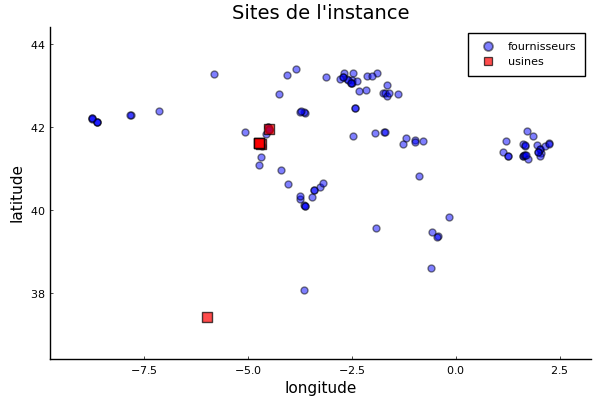

In [43]:
plot_sites(instance_espagne)

# Solution

In [10]:
using JuMP
using Gurobi
import LightGraphs
const lg = LightGraphs

LightGraphs

## Func def

In [59]:
function create_graph(G_original, dims, us, fs, es, J_init, J_fin, e)
    U = dims.U
    F = dims.F
    J = J_fin - J_init + 1
    # J = dims.J
    cost_dispatch = dims.γ
    L = dims.L
    
    G = SimpleDiGraph((3 * U + 4 * F) * J + U + F + 1)
    capacity = zeros((3 * U + 4 * F) * J + U + F + 1, 
        (3 * U + 4 * F) * J + U + F + 1)
    cost_mat = zeros((3 * U + 4 * F) * J + U + F + 1, 
        (3 * U + 4 * F) * J + U + F + 1)
    
    for j = 1:J # for each day
        for u = 1:U # connect each u to each f stock
            for f = 1:F
                add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                    (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1)
                capacity[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                    (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1] += Inf
                cost_mat[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                    (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1] += (G_original.d[u, U + f] * cost_dispatch + dims.ccam + dims.cstop) / L * es[e].l
            end
        end
        
        for f = 1:F
            # connect fictive u (carton) to each f consommation
            add_edge!(G, nv(G), (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f)
            #add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f, nv(G)) # cycle
            capacity[nv(G), (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f] += Inf
            #capacity[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f, nv(G)] += Inf
            cost_mat[nv(G), (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f] += fs[f].cexc[e]
            # cost_mat[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f, nv(G)] += fs[f].cexc[e]
        end
    end
    
    for j = 1:J
        for u = 1:U
            # connect u day j to two additional vertices
            add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 2)
            add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 3)
            
            capacity[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 2] += us[u].r[e, j + J_init - 1]
            capacity[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 3] += Inf
            
            cost_mat[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 3] += us[u].cs[e]
            
            if j < J
                # connect two additional vertices to u day j+1
                add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 2, 
                    j * (3 * U + 4 * F) + 3 * (u - 1) + 1)
                add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 3, 
                    j * (3 * U + 4 * F) + 3 * (u - 1) + 1)
                
                capacity[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 2, 
                    j * (3 * U + 4 * F) + 3 * (u - 1) + 1] += us[u].r[e, j + J_init - 1]
                capacity[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 3, 
                    j * (3 * U + 4 * F) + 3 * (u - 1) + 1] += Inf
            end
        end
        
        for f = 1:F
            # connect f stock day j to two additional vertices
            add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 2)
            add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 3)
            
            capacity[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 2] += fs[f].r[e, j + J_init - 1]
            capacity[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 3] += Inf
            
            cost_mat[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, 
                (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 3] += fs[f].cs[e]
            
            if j < J
                # connect each f stock to f consommation of the next day
                add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, j * (3 * U + 4 * F) + 3 * U + 4 * f)
                capacity[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1, j * (3 * U + 4 * F) + 3 * U + 4 * f] += Inf
                
                # connect two additional vertices to f day j+1
                add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 2, 
                    j * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1)
                add_edge!(G, (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 3, 
                    j * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1)
                
                capacity[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 2, 
                    j * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1] += fs[f].r[e, j + J_init - 1]
                capacity[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 3, 
                    j * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1] += Inf
            end
        end
    end
    
    # connect initial stock to the stock of day 1 (for each u)
    for u = 1:U
        add_edge!(G, (3 * U + 4 * F) * J + u, 3 * (u - 1) + 1)
        
        capacity[(3 * U + 4 * F) * J + u, 3 * (u - 1) + 1] += Inf
    end
    
    # connect initial stock to the stock of day 1 (for each f) & to the f consommation of day 1
    for f = 1:F
        add_edge!(G, (3 * U + 4 * F) * J + U + f, 3 * U + 4 * (f - 1) + 1)  
        add_edge!(G, (3 * U + 4 * F) * J + U + f, 3 * U + 4 * f)
        
        capacity[(3 * U + 4 * F) * J + U + f, 3 * U + 4 * (f - 1) + 1] += Inf
        capacity[(3 * U + 4 * F) * J + U + f, 3 * U + 4 * f] += Inf
    end
    
    return G, capacity, cost_mat
end

create_graph (generic function with 1 method)

In [60]:
# for a given e
function set_demand(dims, us, fs, J_init, J_fin, e) # b parameter
    U = dims.U
    F = dims.F
    J = J_fin - J_init + 1
    # J = dims.J
    demand = zeros((3 * U + 4 * F) * J + U + F + 1)
    
    for j = 1:J
        # for each u
        for u = 1:U
            demand[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1] -= us[u].b⁺[e, j + J_init - 1]
        end
        
        # for each f consommation
        for f = 1:F
            demand[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f] += fs[f].b⁻[e, j + J_init - 1]
        end
    end
    
    # for initial stock
    if J_init <= 1
        for u = 1:U
            demand[J * (3 * U + 4 * F) + u] -= us[u].s0[e]
        end
    
        for f = 1:F
            demand[J * (3 * U + 4 * F) + U + f] -= fs[f].s0[e]
        end
    else
        for u = 1:U
            demand[J * (3 * U + 4 * F) + u] -= us[u].s[e, J_init - 1]
        end
        
        for f = 1:F
            demand[J * (3 * U + 4 * F) + U + f] -= fs[f].s[e, J_init - 1]
        end
    end
    
    println(sum(demand))
    # additional vertices from day 1 to day J-1: b = 0
    # additional vertices of day J: b >= 0
    demand[(3 * U + 4 * F) * J + U + F + 1] += Inf # +Inf means that b is not fixed
    for u = 1:U
        demand[(J - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 2] -= Inf # -Inf means b>=0
        demand[(J - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 3] -= Inf
    end
    for f = 1:F
        demand[(J - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 2] -= Inf
        demand[(J - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 3] -= Inf
    end
    
    return demand
end

set_demand (generic function with 1 method)

In [61]:
function min_cost_flow(g, node_demand, edge_capacity, edge_cost, optimizer)
    m = JuMP.Model(optimizer)
    vtxs = vertices(g)
    
    source_nodes = [v for v in vtxs if node_demand[v] < 0 && node_demand[v] != -Inf]
    sink_nodes = [v for v in vtxs if node_demand[v] > 0 && node_demand[v] != Inf]
    
    idx_dict = Dict()
    ridx_dict = Dict()
    i = 1
    for e in lg.edges(g)
        idx_dict[i] = [src(e), dst(e)]
        ridx_dict[(src(e), dst(e))] = i
        i += 1
    end
    
    @variable(m, 0 <= f[i = 1:ne(g)] <= edge_capacity[idx_dict[i][1], idx_dict[i][2]], Int)
    @objective(m, Min, sum(f[i] * edge_cost[idx_dict[i][1], idx_dict[i][2]] for i = 1:ne(g)))
    # @variable(m, 0 <= f[i=vtxs, j=vtxs; (i,j) in lg.edges(g)] <= edge_capacity[i, j])
    # @objective(m, Min, sum(f[src(e),dst(e)] * edge_cost[src(e), dst(e)] for e in lg.edges(g)))

    for v in lg.vertices(g)
        if v in source_nodes
            @constraint(m,
                sum(f[ridx_dict[(v, vout)]] for vout in outneighbors(g, v)) - sum(f[ridx_dict[(vin, v)]] for vin in lg.inneighbors(g, v)) == -node_demand[v]
            )
        elseif v in sink_nodes
            @constraint(m,
                sum(f[ridx_dict[(vin, v)]] for vin in lg.inneighbors(g, v)) - sum(f[ridx_dict[(v, vout)]] for vout in outneighbors(g, v)) == node_demand[v]
            )
        else
            if node_demand[v] == -Inf
                @constraint(m, sum(f[ridx_dict[(vin, v)]] for vin in lg.inneighbors(g, v)) - sum(f[ridx_dict[(v, vout)]] for vout in outneighbors(g, v)) >= 0)
            elseif node_demand[v] != Inf
                @constraint(m,
                    sum(f[ridx_dict[(vin, v)]] for vin in lg.inneighbors(g, v)) == sum(f[ridx_dict[(v, vout)]] for vout in outneighbors(g, v))
                )
            end
        end
    end

    optimize!(m)
    ts = termination_status(m)
    result_flow = spzeros(nv(g), nv(g))
    if ts != MOI.OPTIMAL
        @warn "Problem does not have an optimal solution, status: $(ts)"
        return result_flow
    end
    for e in lg.edges(g)
        (i,j) = Tuple(e)
        result_flow[i,j] = JuMP.value(f[ridx_dict[(i,j)]])
    end
    return result_flow
    
end

min_cost_flow (generic function with 1 method)

In [62]:
function run_opt(g, dims, us, fs, es, J_init, J_fin, e, optimizer)
    g, capacity, cost_mat = create_graph(g, dims, us, fs, es, J_init, J_fin, e)
    demand = set_demand(dims, us, fs, J_init, J_fin, e)
    flow = min_cost_flow(g, demand, capacity, cost_mat, optimizer)
    return flow
end

run_opt (generic function with 1 method)

In [63]:
function read_flow(flow, U, F, J_init, J_fin)
    # create a U * F * J matrix (for a given e) for dispatching
    # create a U * J matrix (for a given e) for stockage
    # create a F * J matrix (for a given e) for stockage
    # create a F * J matrix (for a given e) for carton consommation
    J = J_fin - J_init + 1
    dispatch = zeros(U, F, J)
    stock_U = zeros(U, J)
    stock_F = zeros(F, J)
    consom_carton = zeros(F, J)
    for j = 1:J
        for u = 1:U
            for f = 1:F
                dispatch[u, f, j] += flow[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1,
                    (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1]
            end
        end
        
        for u = 1:U
            stock_U[u, j] = flow[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 2] +
            flow[(j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 1, (j - 1) * (3 * U + 4 * F) + 3 * (u - 1) + 3]
        end
        
        for f = 1:F
            stock_F[f, j] = flow[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1,
                (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 2] + 
            flow[(j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 1,
                (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * (f - 1) + 3]
            
            consom_carton[f, j] = flow[size(flow)[1], (j - 1) * (3 * U + 4 * F) + 3 * U + 4 * f]
        end
    end
    
    return dispatch, consom_carton, stock_U, stock_F
end

read_flow (generic function with 1 method)

## Test

In [64]:
flow = run_opt(graphe_espagne, dims_espagne, usines_espagne, fournisseurs_espagne, emballages_espagne, 1, 21, 17, Gurobi.Optimizer)

-6.0
Academic license - for non-commercial use only - expires 2021-02-15
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 9989 rows, 28861 columns and 55349 nonzeros
Model fingerprint: 0xca8443b5
Variable types: 0 continuous, 28861 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e+00, 2e+02]
  Bounds range     [1e+00, 2e+02]
  RHS range        [1e+00, 7e+01]
Presolve removed 7574 rows and 19344 columns
Presolve time: 0.10s
Presolved: 2415 rows, 9517 columns, 18858 nonzeros
Variable types: 0 continuous, 9517 integer (2298 binary)

Root relaxation: objective 8.792547e+03, 313 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    8792.5473077 8792.54731  0.00%     -    0s

Explored 0 n

9990×9990 SparseMatrixCSC{Float64,Int64} with 236 stored entries:
  [9876,   16]  =  9.0
  [16  ,   17]  =  5.0
  [10  ,   39]  =  9.0
  [16  ,   39]  =  8.0
  [9882,   42]  =  68.0
  [9901,  118]  =  1.0
  [9922,  199]  =  4.0
  [199 ,  200]  =  4.0
  [9990,  202]  =  4.0
  [10  ,  215]  =  5.0
  [9926,  218]  =  6.0
  [9951,  318]  =  1.0
  ⋮
  [8305, 8778]  =  1.0
  [8471, 8940]  =  29.0
  [8940, 8941]  =  29.0
  [8477, 8946]  =  7.0
  [8946, 8947]  =  7.0
  [8592, 9061]  =  1.0
  [9061, 9062]  =  1.0
  [8941, 9410]  =  29.0
  [9410, 9411]  =  29.0
  [8947, 9416]  =  7.0
  [9416, 9417]  =  7.0
  [9062, 9531]  =  1.0
  [9531, 9532]  =  1.0

In [22]:
disp, consom_carton, stock_U, stock_F = read_flow(flow, dims_espagne.U, dims_espagne.F, 1, 21)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 3.0 11.0 … 121.0 121.0; … ; 0.0 0.0 … 0.0 0.0; 32.0 59.0 … 358.0 358.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [131]:
sum(disp)

208.0

In [133]:
stock_U

6×21 Array{Float64,2}:
  0.0   0.0   0.0    0.0    0.0    0.0  …    0.0    0.0    0.0    0.0    0.0
  3.0  11.0   0.0    0.0   17.0   17.0      87.0  104.0  121.0  121.0  121.0
 21.0  40.0  54.0   71.0   93.0   93.0     245.0  266.0  288.0  288.0  288.0
  2.0   4.0   6.0    7.0    8.0    8.0      22.0   23.0   24.0   24.0   24.0
  0.0   0.0   0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
 32.0  59.0  83.0  107.0  126.0  126.0  …  316.0  339.0  358.0  358.0  358.0

In [134]:
sum(usines_espagne[2].b⁺[7,:])

255

In [141]:
s = 0
for f = 1:dims_espagne.F
    s += fournisseurs_espagne[f].s0[7]
end
s

47

In [136]:
g, capacity, cost_mat = create_graph(graphe_espagne, dims_espagne, usines_espagne, fournisseurs_espagne, 1, 21, 3)

({9990, 28861} directed simple Int64 graph, [0.0 1.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [137]:
sum(flow[nv(g),:])

371.0

In [138]:
sum(consom_carton)

371.0

# First Fit Decreasing

In [164]:
function get_disp_all_E(graphe, dims, usines, fournisseurs, emballages)
    disp_all_E = zeros(dims.U,dims.F,dims.J,dims.E)
    for e in 1:dims.E
        print(e, '\n')
        flow = run_opt(graphe, dims, usines, fournisseurs, emballages, 1, dims.J, e, Gurobi.Optimizer)
        disp, consom_carton, stock_U, stock_F = read_flow(flow, dims.U, dims.F, 1, dims.J)
        disp_all_E[:,:,:,e] = disp[:,:,:]
    end
        return disp_all_E
end


get_disp_all_E (generic function with 1 method)

In [73]:
function get_items(u,f,j,disp_all_E,le,E)
    qe = disp_all_E[u,f,j,:]
    items = Int[]
    for i in 1:E
        if qe[i] != 0
            for j in 1:qe[i]
                append!(items,le[i])
            end
        end
    end
    return items
end


get_items (generic function with 1 method)

In [74]:
function heur_FFD(L, items)
    n = size(items)
    order = sortperm(items, rev=true)
    bin_for_items = fill(-1,n)
    bin_space = []
    for i in order
        if length(bin_space) > 0
            for j in 1:length(bin_space)
                if items[i] <= bin_space[j]
                    bin_for_items[i] = j
                    bin_space[j] -= items[i]
                    break
                end
            end
        end

        if bin_for_items[i] < 0
            j = length(bin_space)
            bin_for_items[i] = j+1
            append!(bin_space, L-items[i])
        end
    end
    n_bins = length(bin_space)
    items_for_bins = []
    for n in 1:n_bins
        n_items = []
        for it in order
            if bin_for_items[it] == n
                append!(n_items, items[it])
            end
        end
        push!(items_for_bins,n_items)
    end
    items_for_bins
    return n_bins,bin_space,items_for_bins
end

heur_FFD (generic function with 1 method)

In [147]:
function get_F_list(u,j,dims,disp_all_E)
    FEflow_uj = Dict{Int64,Array{Int64}}()
    F_totalE = Dict{Int64, Int64}()
    F_list = []
    disp_all_E
    for f in 1:dims.F
        if sum(disp_all_E[u,f,j,:])>0
            FEflow_uj[f] = disp_all_E[u,f,j,:]
            F_totalE[f] = sum(disp_all_E[u,f,j,:])
            append!(F_list, f)
        end
    end
    return F_list
end

get_F_list (generic function with 1 method)

In [160]:
function get_rest_vol(rest_items_f)
    f_rest_vol = 0
    for i in length(rest_items_f)
        f_rest_vol += sum(rest_items_f[1])
    end
    return f_rest_vol
end

get_rest_vol (generic function with 1 method)

In [137]:
# calculate first big f

function get_route_1f(u,j,F_list, dims,disp_all_E, le, E)
    route_1f = Dict{Int64,Int64}() # dict of path of 1 stop, id of f : nb of camion on this path
    rest_items = Dict{Int64,Array}()
    for f in F_list
        items = get_items(u,f,j,disp_all_E,le,E)
        n_bins,bin_space,items_for_bins = heur_FFD(dims.L, items)
        for n in 1:n_bins
            if bin_space[n] > dims.L *0.3
                if f in collect(keys(rest_items))
                    append!(rest_items[f],items_for_bins)
                else
                    rest_items[f] = items_for_bins
                end
            else
                if f in collect(keys(route_1f))
                    route_1f[f] += 1
                else
                    route_1f[f] = 1
                end
            end
        end
    end
    return route_1f, rest_items
end

get_route_1f (generic function with 2 methods)

In [161]:
# routing for rest f
# assume: f is passed by only one camion

function get_route_multi_f(rest_items,dims,usines,fournisseurs,graphe)
    point_depart = usines[u].v
    rest_F_open = collect(keys(rest_items))
    rest_sol = [0]
    rest_bin_space = dims.L
    rest_bins_nb = 0
    stop = 0

    while length(rest_F_open)>0
        rest_F_open = sort(rest_F_open, by=f->graphe.d[point_depart, fournisseurs[f].v])
        for i in 1:length(rest_F_open)
            f = rest_F_open[i]
            f_rest_vol = get_rest_vol(rest_items[f])
            if rest_bin_space >= f_rest_vol
                stop += 1
                append!(rest_sol, f)
                rest_bin_space -= f_rest_vol
                splice!(rest_F_open, i)
                point_depart = fournisseurs[f].v
                if stop%4 == 0 && length(rest_F_open)>0
                    rest_bins_nb += 1
                    append!(rest_sol,0)
                    point_depart = usines[u].v
                    rest_bin_space = dims.L
                end
                break
            else
                if i == length(rest_F_open)
                    rest_bins_nb += 1
                    append!(rest_sol,0)
                    point_depart = usines[u].v
                    rest_bin_space = dims.L
                end
            end
        end
    end
    return rest_sol
end

get_route_multi_f (generic function with 1 method)

In [140]:
# calculate cost

function get_camion_cost(route_1f, rest_sol,dims,usines,fournisseurs,graphe)
    cost_camion = 0.0
    point_depart = usines[u].v
    # for route of 1f
    for f in collect(keys(route_1f))
        one_camion_cost = dims.cstop + dims.γ * graphe.d[usines[u].v, fournisseurs[f].v]
        cost_camion += one_camion_cost * route_1f[f]
    end

    for f in rest_sol
        if f == 0
            cost_camion += dims.ccam
            point_depart = usines[u].v
        else
            cost_camion += dims.cstop + dims.γ * graphe.d[point_depart, fournisseurs[f].v]
            point_depart = fournisseurs[f].v
        end
    end

    return cost_camion
end

get_camion_cost (generic function with 1 method)

In [168]:
function run_heur_route(graphe, dims, usines, fournisseurs, emballages)
    disp_all_E = get_disp_all_E(graphe, dims, usines, fournisseurs, emballages)
    le = []
    for e in 1: dims.E
        append!(le,emballages[e].l)
    end
    camion_cost = 0

    for u in 1:dims.U
        for j in 1:dims.J
            F_list = get_F_list(u,j,dims,disp_all_E)
            route_1f, rest_items = get_route_1f(u,j,F_list, dims, disp_all_E, le, dims.E)
            rest_sol = get_route_multi_f(rest_items,dims,usines,fournisseurs,graphe)
            camion_cost += get_camion_cost(route_1f, rest_sol,dims,usines,fournisseurs,graphe)
        end
    end
    return camion_cost
end

run_heur_route (generic function with 1 method)

In [167]:
dims = dims_espagne
graphe = graphe_espagne
usines = usines_espagne
fournisseurs = fournisseurs_espagne
emballages = emballages_espagne
camion_cost = run_heur_route(graphe, dims, usines, fournisseurs, emballages)

1
23.0
Academic license - for non-commercial use only - expires 2021-02-15
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 9989 rows, 28861 columns and 55349 nonzeros
Model fingerprint: 0x1bd71ef0
Variable types: 0 continuous, 28861 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 1e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 8e+00]
Presolve removed 7574 rows and 19264 columns
Presolve time: 0.11s
Presolved: 2415 rows, 9597 columns, 18941 nonzeros
Variable types: 0 continuous, 9597 integer (2266 binary)

Root relaxation: objective 7.299423e+03, 431 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    7299.4230769 7299.42308  0.00%     -    0s

Explored 0

8
-168.0
Academic license - for non-commercial use only - expires 2021-02-15
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 9989 rows, 28861 columns and 55349 nonzeros
Model fingerprint: 0x96edd9e4
Variable types: 0 continuous, 28861 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 5e+01]
  Bounds range     [1e+00, 3e+02]
  RHS range        [1e+00, 6e+01]
Presolve removed 7513 rows and 12074 columns
Presolve time: 0.19s
Presolved: 2476 rows, 16787 columns, 33361 nonzeros
Variable types: 0 continuous, 16787 integer (2424 binary)

Root relaxation: objective 5.551849e+03, 2795 iterations, 0.30 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    5551.8492308 5551.84923  0.00%     -    0s

Explo

0.0
Academic license - for non-commercial use only - expires 2021-02-15
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 9989 rows, 28861 columns and 55349 nonzeros
Model fingerprint: 0xbbc0fd97
Variable types: 0 continuous, 28861 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%

User-callback calls 21, time in user-callback 0.00 sec
17
-6.0
Academic license - for non-commercial use only - expires 2021-02-15
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thre

23
18.0
Academic license - for non-commercial use only - expires 2021-02-15
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 9989 rows, 28861 columns and 55349 nonzeros
Model fingerprint: 0xd634f203
Variable types: 0 continuous, 28861 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e+00, 2e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 2e+01]
Presolve removed 7560 rows and 16837 columns
Presolve time: 0.21s
Presolved: 2429 rows, 12024 columns, 23767 nonzeros
Variable types: 0 continuous, 12024 integer (3398 binary)

Root relaxation: objective 1.207909e+04, 676 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    12079.086538 12079.0865  0.00%     -    0s

Explore

(Dict{Int64,Int64}(), [0], 575526.0)